                                     SARIMAX Results                                      
Dep. Variable:                  EnergyConsumption   No. Observations:                 1000
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood               -3371.380
Date:                            Sun, 21 Sep 2025   AIC                           6752.760
Time:                                    17:57:48   BIC                           6777.037
Sample:                                01-01-2022   HQIC                          6762.010
                                     - 02-11-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0140      0.033      0.427      0.669      -0.050       0.078
ma.L1         -1.0061      0.007   

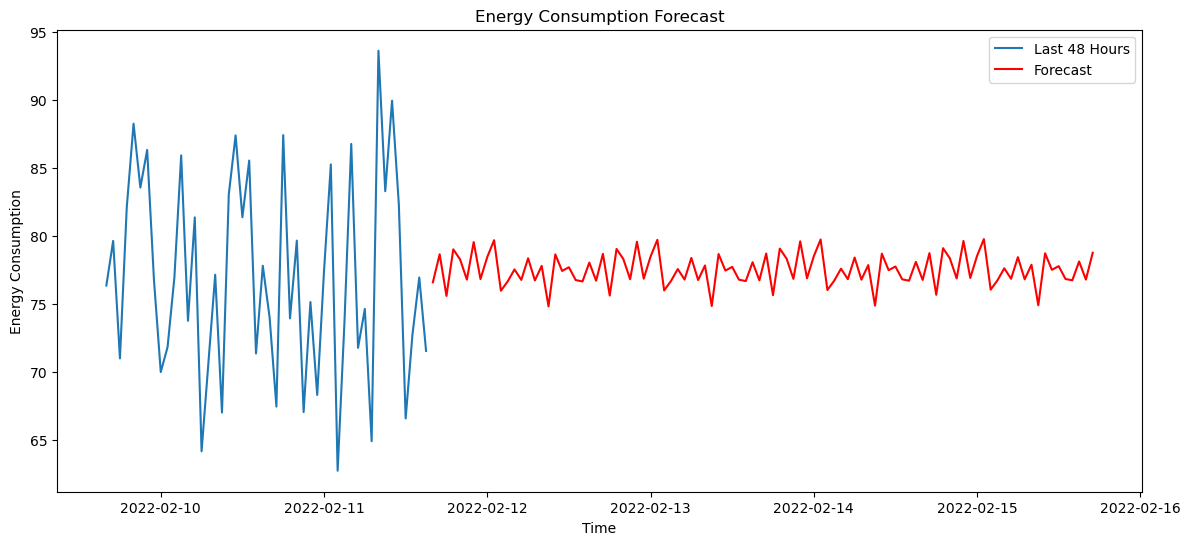

In [66]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# -------------------------------
# 1. Load dataset
# -------------------------------
df = pd.read_csv("cleaned_energy_hourly.csv")
df['Timestamp'] = pd.to_datetime(df['Timestamp'], dayfirst=True)
df['EnergyConsumption'] = pd.to_numeric(df['EnergyConsumption'], errors='coerce')

# Sort and set datetime index
df = df.sort_values('Timestamp')
df.set_index('Timestamp', inplace=True)
df = df.asfreq('h')  # ensure continuous hourly data
df['EnergyConsumption'] = df['EnergyConsumption'].ffill()

# -------------------------------
# 2. Fit SARIMA model
# -------------------------------
# daily seasonality for hourly data: m=24
model = SARIMAX(df['EnergyConsumption'],
                order=(1,1,1),
                seasonal_order=(1,1,1,24),
                enforce_stationarity=False,
                enforce_invertibility=False)

fit = model.fit(disp=False)
print(fit.summary())

# -------------------------------
# 3. Forecast for user-specified datetime
# -------------------------------
user_input = input("Enter future datetime (DD-MM-YYYY HH:MM): ")
forecast_time = pd.to_datetime(user_input, dayfirst=True)

last_time = df.index[-1]
hours_ahead = int((forecast_time - last_time).total_seconds() / 3600)

if hours_ahead <= 0:
    print("Error: Enter a datetime after the last data point:", last_time)
else:
    forecast = fit.get_forecast(steps=hours_ahead)
    forecasted_value = forecast.predicted_mean.iloc[-1]
    print(f"\n📌 Forecasted Energy Consumption at {forecast_time}: {forecasted_value:.2f} units")

# -------------------------------
# 4. Optional: plot last 48 hours + forecast
# -------------------------------
import matplotlib.pyplot as plt

forecast_index = pd.date_range(start=last_time + pd.Timedelta(hours=1), periods=hours_ahead, freq='h')
forecast_series = pd.Series(forecast.predicted_mean.values, index=forecast_index)

plt.figure(figsize=(14,6))
plt.plot(df['EnergyConsumption'][-48:], label='Last 48 Hours')
plt.plot(forecast_series, color='red', label='Forecast')
plt.title('Energy Consumption Forecast')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()


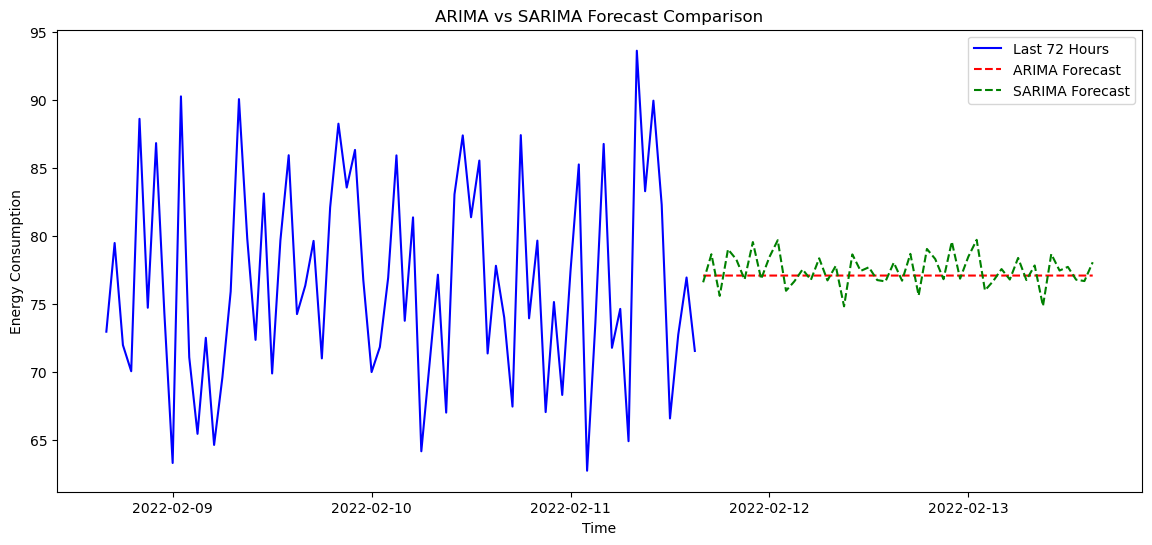

ARIMA Forecast (first 5 hours):
2022-02-11 16:00:00    77.090025
2022-02-11 17:00:00    77.093024
2022-02-11 18:00:00    77.093026
2022-02-11 19:00:00    77.093026
2022-02-11 20:00:00    77.093026
Freq: h, Name: predicted_mean, dtype: float64

SARIMA Forecast (first 5 hours):
2022-02-11 16:00:00    76.596694
2022-02-11 17:00:00    78.661400
2022-02-11 18:00:00    75.595973
2022-02-11 19:00:00    79.023944
2022-02-11 20:00:00    78.282795
Freq: h, Name: predicted_mean, dtype: float64


In [68]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# -------------------------------
# 1. Load dataset
# -------------------------------
df = pd.read_csv("cleaned_energy_hourly.csv")
df['Timestamp'] = pd.to_datetime(df['Timestamp'], dayfirst=True)
df['EnergyConsumption'] = pd.to_numeric(df['EnergyConsumption'], errors='coerce')

# Sort and set index
df = df.sort_values('Timestamp')
df.set_index('Timestamp', inplace=True)
df = df.asfreq('h')  # ensure hourly frequency
df['EnergyConsumption'] = df['EnergyConsumption'].ffill()

# -------------------------------
# 2. Forecast horizon
# -------------------------------
forecast_steps = 48  # next 48 hours

# -------------------------------
# 3. Fit ARIMA (1,1,1)
# -------------------------------
arima_model = ARIMA(df['EnergyConsumption'], order=(1,1,1))
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=forecast_steps)

# -------------------------------
# 4. Fit SARIMA (1,1,1)(1,1,1,24)
# -------------------------------
sarima_model = SARIMAX(df['EnergyConsumption'],
                       order=(1,1,1),
                       seasonal_order=(1,1,1,24),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarima_fit = sarima_model.fit(disp=False)
sarima_forecast = sarima_fit.get_forecast(steps=forecast_steps).predicted_mean

# -------------------------------
# 5. Forecast index
# -------------------------------
last_time = df.index[-1]
forecast_index = pd.date_range(start=last_time + pd.Timedelta(hours=1), periods=forecast_steps, freq='h')

# -------------------------------
# 6. Plot comparison
# -------------------------------
plt.figure(figsize=(14,6))
plt.plot(df['EnergyConsumption'][-72:], label='Last 72 Hours', color='blue')
plt.plot(forecast_index, arima_forecast, label='ARIMA Forecast', color='red', linestyle='--')
plt.plot(forecast_index, sarima_forecast, label='SARIMA Forecast', color='green', linestyle='--')
plt.title('ARIMA vs SARIMA Forecast Comparison')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()

# -------------------------------
# 7. Print first 5 forecasted values
# -------------------------------
print("ARIMA Forecast (first 5 hours):")
print(arima_forecast.head())

print("\nSARIMA Forecast (first 5 hours):")
print(sarima_forecast.head())
